# Here I fit the Curie-Weiss Law to the Magnetization vs Temeperature data as measured by the PPMS-VSM. 
### Note that reading in mass and type of file is hardcoded to follow my lab's convention for file naming.

# We typically look at two types of runs, Field Cooling (FC) and Zero-Field Cooling (ZFC).
## If the Weiss constant is negative we have an antiferromagnet, if the Weiss constant is positive we have a ferromagnet.
## We get the effective magnetic moment and g-factor from Curie's constant

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model
import seaborn as sns
import pandas as pd
sns.set()

import sys
sys.path.append('..')
from JensenTools import *

## My functions

In [12]:
# Takes a filename and data directory
# Returns the field, magnetic moment, error, and name (temperature) of the run
# field, moment, and error are returned as np arrays
# name is returned as a string
## Note that the name handling is hardcoded for how my lab conventionally names our files.
def getData(magrun, dataDir):
    mass = getMass(magrun)
    measType = magrun.split('_')[5].split('.')[0]
    df = pd.read_csv(dataDir+magrun)
    df.dropna(inplace = True)
    T = np.array(df['Temperature (K)'])
    H = np.array(df['Magnetic Field (Oe)'])
    E = np.array(df['M. Std. Err. (emu)'])
    M = np.array(df['Moment (emu)'])
    return M,H,T,E, mass, measType

# Takes a filename
# Returns mass in grams
def getMass(filename):
    mass = filename.split('_')[2]
    mass = mass.replace('P','.')
    mass = mass[:-2]
    return float(mass)/1000

# This is the inverse of the Curie-Weiss Law.
# We will be creating an LMFIT model with this and fitting for:
## Curie's constant 'c', Weiss' constant 'wc'
def Curiei(t,c,wc):
    return(t-wc)/c

# Takes in Curie's constant and the system's total angular momentum J value
# Returns effective moment (bohr magnetons) and effective g-factor
def calcConstants(c,J):
    ueff = np.sqrt(8*c)
    gj = ueff/np.sqrt(J*(J+1))
    return ueff, gj

## Manually enter the sample name, molecular weight, and mass error (for our scales  .00005 g)
https://www.lenntech.com/calculators/molecular/molecular-weight-calculator.htm


In [13]:
comp = 'ErOI'
molweight = 310.16
massErr = .00005

## Load the M vs T data file names into a list and create a dictionary 'data' which holds all of the measured data for that type of measurement
### { 'FC/ZFC' : [Magnetization, Applied Field, Temperature, Magnetization error, samplemass] }

In [14]:
dataDir = 'data/'
runs = []
for i in os.listdir(dataDir):
    if i.endswith('.DAT'):
        runs.append(i)       
data = {}
for i in runs:
    M,H,T,MErr,samplemass,measType = getData(i,dataDir)
    data[measType] = [M,H,T,MErr,samplemass]
    

M,H,T,MErr,samplemass = data['ZFC']

## Calculate the Susceptibility and Susceptibility Error (normalized to emu Oe^-1 Mol^-1) with error propagation

## Calculate the inverse of these two with error propagation


In [15]:
# SuscNorm = []
# SuscErrorNorm = []
# for i in range(len(M)):
#     SuscNorm.append(M[i]/H[i]*molweight/samplemass/1)
#     SuscErrorNorm.append(Err[i]/H[i]*molweight/samplemass + M[i]/H[i]*molweight*massE/(samplemass**2))

# Xi = 1/np.array(SuscNorm)
# XiErr = np.array(SuscErrorNorm)/np.array(SuscNorm)**2

X,XErr,Xi,XiErr = normSusc(M,H,MErr,molweight,samplemass,massErr)

## Choose a range of temperatures to fit over 'tr', create the LMFIT model, make an initial guess for 'c' and 'wc', fit over desired range, create a full line using the fitted parameters


In [16]:
tr = [300,400] #temprange = [low,high]

cmodeli =  Model(Curiei, independent_vars = ['t'])
params = cmodeli.make_params()
params['wc'].set(value = 10)
params['c'].set(value = 10)
newT = []
newXi = []
newE = []
for i in range(len(T)):
    if (T[i] >= tr[0] and T[i]<= tr[1]):
        newT.append(T[i])
        newXi.append(Xi[i])
        newE.append(XiErr[i])

resulti = cmodeli.fit(newXi, params, t = newT, weights = newE) #fit

fullLine = []
for i in T:
    fullLine.append(Curiei(i,resulti.params['c'].value,resulti.params['wc'].value))


## Plot the inverse suscptibility and the fit as well as calculated constants

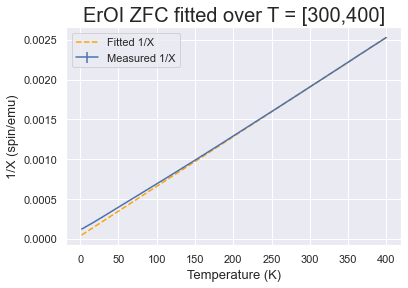

The Weiss constant = -5.05 K
The Curie constant = 160115.636
Effective moment for ErOI is 1131.780 bohr magnetons, with J=0.5 -> gj factor = 1306.867


In [17]:
plt.errorbar(T,Xi,yerr = XiErr,label = 'Measured 1/X')
plt.plot(T,fullLine,'orange', linestyle = '--', label = 'Fitted 1/X')
plt.title("{} {} fitted over T = [{},{}]".format(comp,measType,tr[0],tr[1]), fontsize = 20)
plt.xlabel('Temperature (K)', fontsize = 13)
plt.ylabel('1/X (spin/emu)', fontsize = 13)
plt.legend()
plt.show()


print('The Weiss constant = {:.2f} K\nThe Curie constant = {:.3f}'.format(resulti.params['wc'].value,resulti.params['c'].value))

J = 1/2
ueff, gj = calcConstants(resulti.params['c'].value,J)

# print(ueff/(mass/molweight)*6.02*10**-23)
print('Effective moment for {:} is {:.3f} bohr magnetons, with J={} -> gj factor = {:.3f}'.format(comp,ueff,J,gj))